In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import figure

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Create an Inspect engine
inspector = inspect(engine)

# Exploratory Climate Analysis

In [10]:
# Inspect both classes to find column types
# Iterate through 'measurement' & 'station' tables
for each in tables:
    # Grab columns
    columns = inspector.get_columns(each)
    print('------------')
    print(f'table {each.title()}')
    
    # print out column names/types
    for c in columns:
        print(c['name'], c['type'])

------------
table Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
table Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


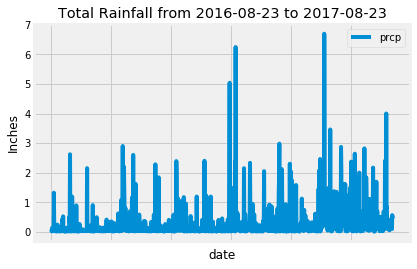

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Change into a datetime obj
date_last = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
date_last
# Calculate a year from last date
year_ago = date_last - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date > year_ago)\
    .all()
prcp_data
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')
prcp_df = prcp_df.replace(0, np.nan)
prcp_df = prcp_df.dropna()
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.title(f"Total Rainfall from {(year_ago.strftime('%Y-%m-%d'))} to {date_last.strftime('%Y-%m-%d')}")
plt.ylabel('Inches')
plt.savefig('Images/Total_rainfall.png')
plt.show()



![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,1142.000000
mean,0.311357
std,0.576134
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station, Station.name).all()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()


# First tuple, 0th item is the most active station
most_active_station = most_active_stations[0][0]
most_active_station

'USC00519281'

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(Measurement.station, func.min(Measurement.tobs), 
              func.max(Measurement.tobs), func.avg(Measurement.tobs))\
            .filter(Measurement.station == most_active_station).all()
temp_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

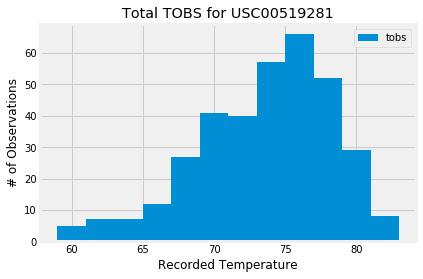

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Collect all the tobs from a year ago til last date
tobs_from_last_year = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date > year_ago)\
    .filter(Measurement.station == most_active_station).all()

# Turn TEMP TOBS result into a DataFrame
tobs_df = pd.DataFrame(tobs_from_last_year)
tobs_df = tobs_df.set_index('date')
tobs_df
# Plot a histogram bar
tobs_df.plot(kind="hist", bins=12)
plt.title(f"Total TOBS for {most_active_station}")
plt.ylabel('# of Observations')
plt.xlabel('Recorded Temperature')
plt.savefig('Images/tobs_most_active_station.png')
plt.show()



![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-24', '2017-08-18'))

[(58.0, 74.53786848072562, 87.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrive_date = dt.date(2016, 7, 24)
leave_date = dt.date(2016, 8, 10) 
last_year = dt.timedelta(days=365)

temp_avg = calc_temps(arrive_date - last_year, leave_date - last_year)
temp_avg

[(69.0, 78.27358490566037, 85.0)]

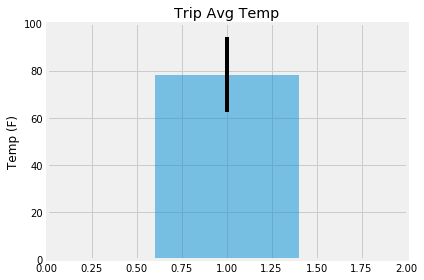

In [20]:
# Plot the results from your previous query as a bar chart. 

fig, ax = plt.subplots()
x_pos = range(len(temp_avg))
tmax = temp_avg[0][2]
tmin = temp_avg[0][0]
# Use the average temperature for the y value
tavg = temp_avg[0][1]
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [tmax-tmin]

# Create bar graph
ax.bar(1, height=tavg, yerr=error, alpha=0.5, ecolor='black')
ax.set_ylabel('Temp (F)')
# Use "Trip Avg Temp" as your Title
ax.set_title('Trip Avg Temp')

# Save the figure and show
plt.savefig('Images/bar_plot_with_error_bars.png')
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()



In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the 
# station, name, latitude, longitude, and elevation

rain_fall = session.query(Station.station, Station.name, func.sum(Measurement.prcp).label('Total Precipitation'),
                         Station.latitude, Station.longitude, Station.elevation)\
    .filter(Station.station == Measurement.station)\
    .filter(Measurement.date > year_ago)\
    .group_by(Station.name)\
    .order_by(func.sum(Measurement.prcp).desc()).all()
rain_fall

# Turn rain result into DataFrame
rain_fall_df = pd.DataFrame(rain_fall)
rain_fall_df = rain_fall_df.set_index('station')
rain_fall_df

,name,Total Precipitation,latitude,longitude,elevation
station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",147.11,21.33310,-157.80250,152.4
USC00519281,"WAIHEE 837.5, HI US",68.24,21.45167,-157.84889,32.9
USC00513117,"KANEOHE 838.1, HI US",48.36,21.42340,-157.80150,14.6
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",37.99,21.33556,-157.71139,19.5
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",33.19,21.52130,-157.83740,7.0
USC00519397,"WAIKIKI 717.2, HI US",16.09,21.27160,-157.81680,3.0
USC00517948,"PEARL CITY, HI US",4.59,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
arrive_date = dt.date(2016, 7, 24)
leave_date = dt.date(2016, 8, 10) 
# Use the start and end date to create a range of dates
full_date_range = pd.date_range(arrive_date, end = leave_date).to_pydatetime().tolist()
# Stip off the year and save a list of %m-%d strings
stripped_dates = []
for date in full_date_range:
    stripped = date.strftime('%m-%d')
    stripped_dates.append(stripped)
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in stripped_dates:
    days_normals = daily_normals(date)
    normals.append(days_normals)

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_mins = []
trip_avgs = []
trip_maxs = []
for norm in normals:
    trip_mins.append(norm[0][0])
    trip_avgs.append(norm[0][1])
    trip_maxs.append(norm[0][2])


# Initialize Dataframe then add columsn
trip_df = pd.DataFrame(trip_mins, columns=['Min'])
trip_df['Avg'] = trip_avgs
trip_df['Max'] = trip_maxs
trip_df['Dates'] = stripped_dates
trip_df = trip_df.set_index('Dates')
trip_df.head()

,Min,Avg,Max
Dates,,,
07-24,69.0,76.555556,81.0
07-25,67.0,76.890909,84.0
07-26,71.0,76.442308,86.0
07-27,68.0,76.581818,83.0
07-28,69.0,76.464286,82.0


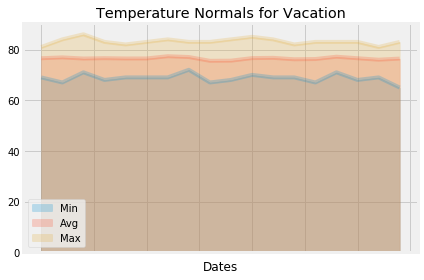

In [47]:
# Plot the daily normals as an area plot with `stacked=False`
# Take out each min, avg, max norms
trip_df.plot.area(stacked=False, alpha=.23)
plt.title('Temperature Normals for Vacation')
plt.tight_layout()
plt.savefig('Images/temp_norms.png')
plt.show()